In [73]:
cd /orange/adamginsburg/jwst/brick/

/blue/adamginsburg/adamginsburg/jwst/brick


In [74]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [75]:
from astropy import coordinates

In [76]:
import numpy as np

In [77]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [78]:
import warnings

In [79]:
import regions

In [80]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [81]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [82]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)

In [83]:
import glob
from astropy.io import fits

In [84]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [85]:
#catfns = glob.glob(f"{basepath}/F*/f[0-9][0-9][0-9][nm]*nrcb_crowdsource.fits")
catfns = [x
          for filn in filternames
          for x in glob.glob(f"{basepath}/{filn.upper()}/{filn.lower()}*nrcb_crowdsource.fits")
         ]
catfns

['/orange/adamginsburg/jwst/brick//F410M/f410m_nrcb_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F212N/f212n_nrcb_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F466N/f466n_nrcb_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F405N/f405n_nrcb_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F187N/f187n_nrcb_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F182M/f182m_nrcb_crowdsource.fits']

In [86]:
# jw02221-o001_t001_nircam_f405n-f444w_i2d.fits
# /orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits
imgfns = [x
          for filn in filternames
          for x in glob.glob(f"{basepath}/{filn.upper()}/pipeline/jw02221-o001_t001_nircam*{filn.lower()}*nrcb*_i2d.fits")
          if 'nrcb_' in x or 'nrcb1_' in x
         ]

print(" ".join(imgfns))
imgfns

/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits /orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb_i2d.fits /orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb1_i2d.fits /orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits /orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits /orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb1_i2d.fits /orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb_i2d.fits /orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb_i2d.fits /orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb1_i2d.fits


['/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb1_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb1_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb1_i2d.fits']

In [87]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #wcses = [wcs.WCS(fits.getheader(fn.replace("_crowdsource", "_crowdsource_skymodel"))) for fn in catfns]
    imgs = [fits.getdata(fn, ext=('SCI', 1)) for fn in imgfns]
    wcses = [wcs.WCS(fits.getheader(fn, ext=('SCI', 1))) for fn in imgfns]

In [88]:
# retrieve fixed, updated WCSes
for ii,filn in enumerate(filternames):
    refitpath = f'{basepath}/reduction/headers/{filn.lower()}_nrcb_refitted_to_f410m.hdr'
    if os.path.exists(refitpath):
        ww = WCS(fits.Header.fromtextfile(refitpath))
        print(f"Replacing filter {filn} with {refitpath}")
        wcses[ii] = ww

Replacing filter f466n with /orange/adamginsburg/jwst/brick//reduction/headers/f466n_nrcb_refitted_to_f410m.hdr
Replacing filter f405n with /orange/adamginsburg/jwst/brick//reduction/headers/f405n_nrcb_refitted_to_f410m.hdr


In [89]:
basepath = '/orange/adamginsburg/jwst/brick/'
reg = regions.Regions.read(f'{basepath}/regions/rightside_brick_zoom.reg')[0]
regzoom = regions.Regions.read(f'{basepath}/regions/rightside_brick_rezoom.reg')[0]

tbls[0].meta['filter'], len(tbls[0])

In [90]:
basetable = Table.read(f'{basepath}/catalogs/crowdsource_nrcb_photometry_tables_merged.fits')

In [104]:
any_saturated_ = [basetable[x] for x in basetable.colnames if 'near_sat' in x]
any_saturated = any_saturated_[0]
for row in any_saturated_[1:]:
    print(row.sum())
    any_saturated = any_saturated | row
any_saturated.sum()

99
178
528
59
1358


3201

In [91]:
tbls = [Table.read(catfn) for catfn in catfns]
# HACK, not needed any more...
for tbl,catfn in zip(tbls, catfns):
    tbl.meta['filter'] = os.path.basename(catfn).split("_")[0]
tbl[:5]

<Table length=5>
        x                   y              flux     passno      dx         dy         dflux          qf        rchi2    fracflux  fluxlbs    dfluxlbs    fwhm   spread_model dspread_model  fluxiso          xiso                yiso           sky                   skycoord               
                                                                                                                                                                                                                                                                      deg,deg                
     float64             float64         float32   float64   float32    float32      float32      float32     float32   float32   float32    float32   float32    float32       float32     float32        float64             float64        float32                 SkyCoord               
------------------ -------------------- ---------- ------- ----------- ---------- ------------- ------------ --------- --------- ---------- --------- --------- ------------ ------------- ---------- ------------------ ------------------- --------- --------------------------------------
1282.4412505030632               -0.499  252355.39     0.0       1e+20      1e+20 10000000000.0          0.0       0.0       0.0        0.0       0.0  2.622974          0.0           0.0        0.0                0.0                 0.0 5.6600175   266.5123388570849,-28.70370809897086
2019.3487901687622 -0.11083360761404037 -8009.3906     0.0  0.05787988 0.17298646     531.08765 0.0024201653 17.184992 1.5305865  2762.7588 1074.0298 2.6155791   0.01987791  0.0031144002  -4615.682 1.2658954902492003  0.2708666806235578 5.5106688 266.51226929417356,-28.697415288108406
2029.3844775776731               -0.499  -5867.377     0.0 0.104686946  0.2501539      573.1131  0.002205424 10.025497 1.1402603  3227.0383 1104.2158 2.6222892 0.0019886494    0.00710303 -6847.7856 0.1197727385356737 0.39661386889081174  5.481151 266.51226451652514,-28.697329622851356
 2073.762616915631               -0.499 -2960.7405     0.0  0.20621286 0.47285262     573.79535  0.002185925 3.9587913 0.8529448 -61.019463 1083.0314 2.6198714  0.028673172   0.009001303  -5404.895 0.3287819156264327 0.21936969390359307  5.348321  266.51226010001443,-28.69695065842854
 2076.411827325821               -0.499  -3794.381     0.0  0.16205853  0.3858499     573.36707  0.002204886  6.438787 0.9302589 -1589.8998 1105.3108 2.6226707  0.011322498   0.006316665   -7340.44 0.2454856979751711 -0.1169102000828698 5.3424172  266.5122598363661,-28.696928035657272

0arcsec [0arcsec 0arcsec 0arcsec ... 0arcsec 0arcsec 0arcsec]
0arcsec
9.46308e-05arcsec [0.109667arcsec -0.0542289arcsec -0.0325431arcsec ... 0.0250348arcsec
 0.106306arcsec 0.0489224arcsec]
0.00020316arcsec
0.000193884arcsec [-0.0279306arcsec 0.0314312arcsec 0.0521465arcsec ... -0.0192922arcsec
 -0.0214584arcsec -0.207616arcsec]
2.16953e-05arcsec
-4.7755e-05arcsec [-0.0324833arcsec 0.0152397arcsec 0.0303148arcsec ... 0.0443125arcsec
 0.00613865arcsec -0.0802104arcsec]
-1.83879e-05arcsec
7.80002e-05arcsec [0.00426508arcsec -0.0579048arcsec -0.0347248arcsec ... 0.0243153arcsec
 0.104454arcsec 0.0457619arcsec]
0.000269684arcsec
0.000352495arcsec [-0.141328arcsec -0.0524693arcsec -0.0333147arcsec ... 0.0198618arcsec
 0.101392arcsec 0.0446arcsec]
0.000289032arcsec


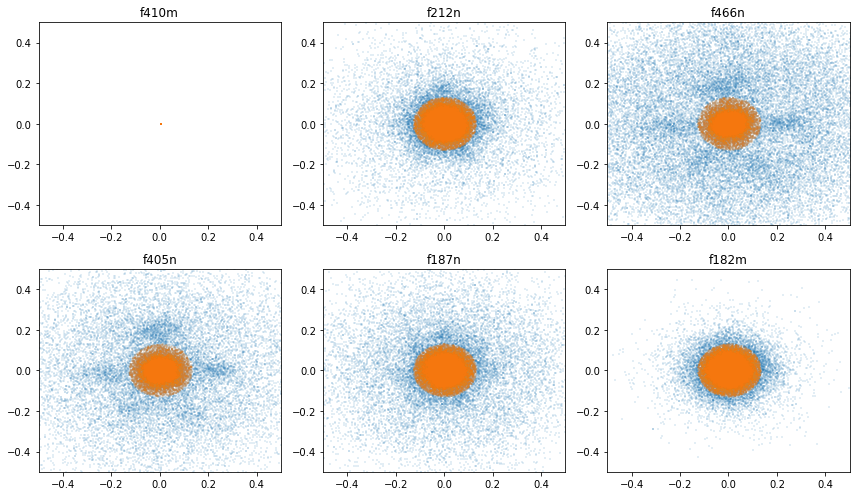

In [92]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoord_f410m']
ii = 1
for tbl in tbls:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoord_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    print(np.median(decdiff))
    ok = (radiff**2 + decdiff**2) < (0.13*u.arcsec)**2
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

f212n 0.04008927947738502 arcsec 0.035800762183117764 arcsec
f466n 0.04624449675120565 arcsec 0.026262658272668438 arcsec
f405n 0.02971566541991815 arcsec 0.024765083606839107 arcsec
f187n 0.04135042495705393 arcsec 0.03470274145486044 arcsec
f182m 0.036994714620273594 arcsec 0.03485566530312753 arcsec


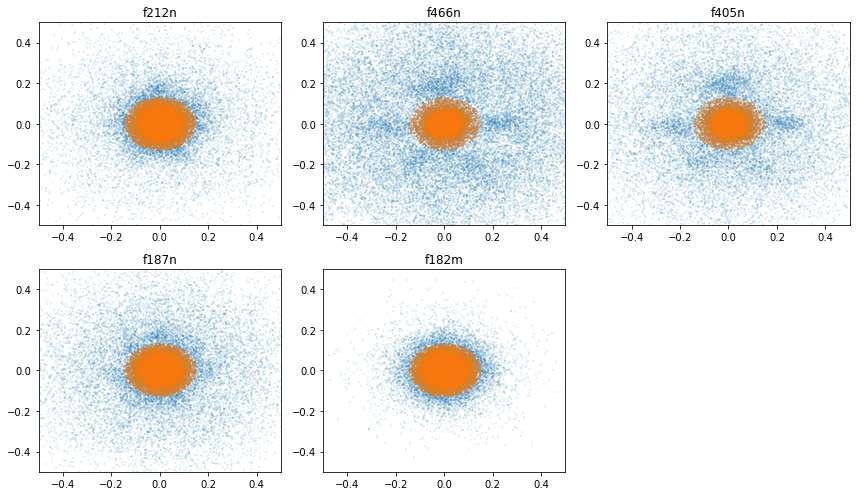

In [93]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoord_f410m']
ii = 1
for tbl in tbls[1:]:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoord_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    #print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    #print(np.median(decdiff))
    sep = basetable[f'sep_{filtername}']
    print(filtername, np.median(sep.to(u.arcsec)), np.median(sep[sep<0.13*u.arcsec].to(u.arcsec)))
    ok = sep < (0.13*u.arcsec)
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [94]:
len(basetable)

69995

In [95]:
basetable[reg.contains(basetable['skycoord_f405n'],ww)][:5]

<Table length=5>
     x_f410m            y_f410m      flux_f410m passno_f410m   dx_f410m     dy_f410m   dflux_f410m  qf_f410m  rchi2_f410m fracflux_f410m fluxlbs_f410m ... mag_ab_f182m near_saturated_f182m flux_jy_410m405 mag_ab_410m405 flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
                                                                                                                                                       ...                                          Jy                             Jy                             Jy                             Jy                     
     float64            float64       float32     float64      float32      float32      float32    float32     float32      float32        float32    ...   float32            bool             float32        float32         float32        float32         float32        float32         float32        float32    
------------------ ----------------- ---------- ------------ ------------ ------------ ----------- ---------- ----------- -------------- ------------- ... ------------ -------------------- --------------- -------------- --------------- -------------- --------------- -------------- --------------- --------------
1547.7034194101095 689.2820527183208   99.08203          0.0   0.00803874   0.00828216  0.48193243        1.0    170.6662     0.99293363    115.745514 ...    19.213774                False  -9.6741576e-05             --    0.0013562506      16.069149   6.0580103e-05      19.444176    1.898309e-05      20.704082
1593.5515511672338 689.5974169568093  278.74844          0.0 0.0037147268 0.0038267607   0.6689526        1.0   135.31448      0.9159197     289.80917 ...    18.122116                False    0.0004721112       17.21489   -0.0015794381             --   0.00016609505       18.34911    4.847003e-05      19.686316
1693.5247656739293   689.21190574311  23.305717          0.0   0.03203273   0.03230972   0.4035493        1.0   49.553528     0.88899577     21.906202 ...    21.764977                False  -0.00021420569             --    0.0017070482      15.819386    5.030442e-06      22.145985    6.717774e-06      21.831936
1560.8384175997062 691.5385300331827  55.678665          0.0  0.012857744  0.013028992    0.426836        1.0    89.11155      0.9761685        68.951 ...    19.516636                False  -0.00019346051             --    0.0017704236      15.779806    4.487519e-05      19.769985   2.0646417e-05      20.612888
1617.6816978972042 690.7840588927253 112.385086          0.0 0.0072682644  0.007354511   0.5067152 0.99999994   48.225323      0.9793549    126.355705 ...     18.91731                False  -0.00016485255             --    0.0019375797       15.68185    7.959696e-05      19.147758   2.4965659e-05      20.406643

In [96]:
basetable[reg.contains(basetable['skycoord_f410m'],ww)][:5]['flux_f410m', 'skycoords_f410m', 'x_f410m', 'y_f410m']

<Table length=5>
flux_f410m            skycoord_f410m                  x_f410m            y_f410m     
                          deg,deg                                                     
 float32                  SkyCoord                     float64            float64     
---------- -------------------------------------- ------------------ -----------------
  99.08203   266.526298127004,-28.686797540309314 1547.7034194101095 689.2820527183208
 278.74844  266.5262905013038,-28.685995207293725 1593.5515511672338 689.5974169568093
 55.678665  266.5263391483193,-28.686567103721032 1560.8384175997062 691.5385300331827
112.385086 266.52630684605646,-28.685572662843594 1617.6816978972042 690.7840588927253
 -9.481374 266.52635344559144,-28.686369889908597 1572.0955737002887 692.4266298962691

In [97]:
#(500*u.Jy).to(u.ABmag)
(basetable[reg.contains(basetable['skycoord_f410m'],ww)][:5]['flux_f410m'] * u.Jy).to(u.ABmag)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


<Magnitude [3.9100127, 2.786969 , 4.535778 , 3.7732282,       nan] mag(AB)>

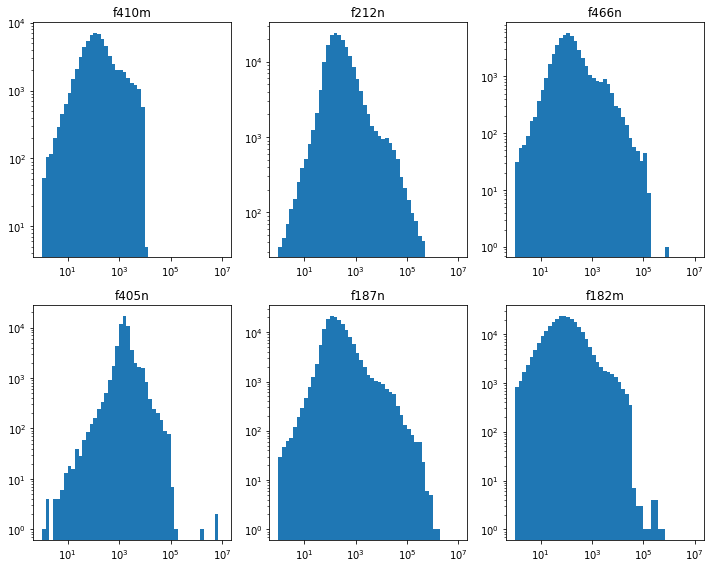

In [98]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux'], bins=np.logspace(0,7), log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

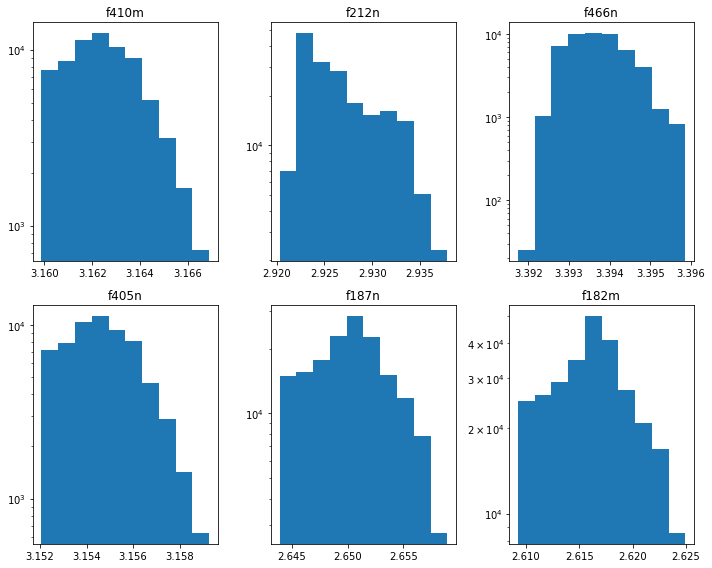

In [99]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['fwhm'], log=True)
    ax.set_title(tbl.meta['filter'])
pl.tight_layout()

# XMatch Check

In [100]:
len(tbls[0]), tbls[0].meta['filter']

(69995, 'f410m')

In [101]:
fh = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits')
ww410 = wcs.WCS(fh[1].header)

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


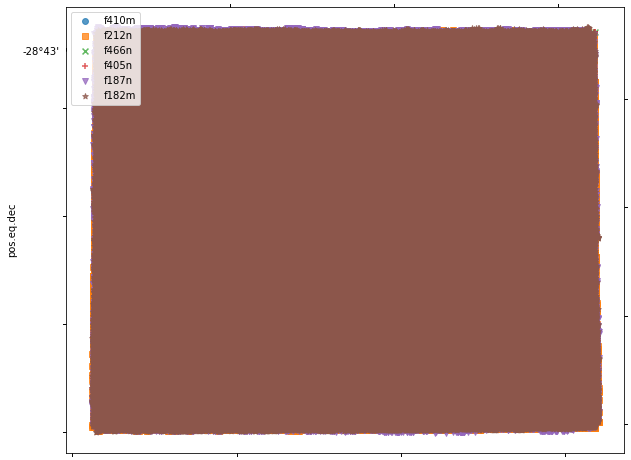

In [102]:
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=ww410)
data410 = imgs[0]
ax.imshow(data410)
for tbl,marker in zip(tbls, 'osx+v*'):
    crds = tbl['skycoord']
    pl.scatter(crds.ra, crds.dec, alpha=0.75, s=35,
               marker=marker, label=tbl.meta['filter'],
               transform=ax.get_transform('world'),
              )
#pl.axis((266.5385, 266.54, -28.740, -28.7385))
pl.legend(loc='best')

# Color-magnitude and color-color diagrams

(25.0, 13.0)

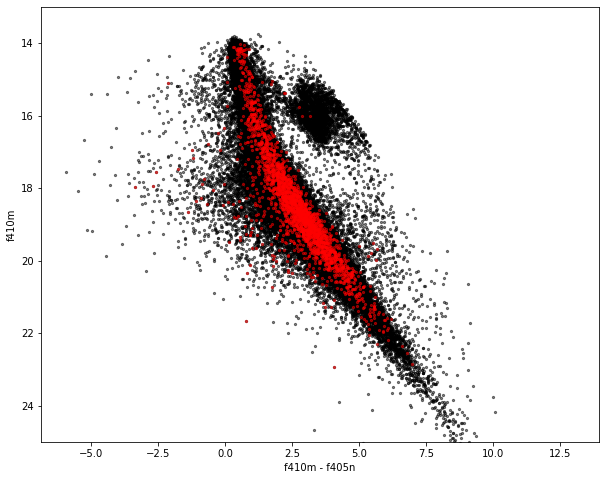

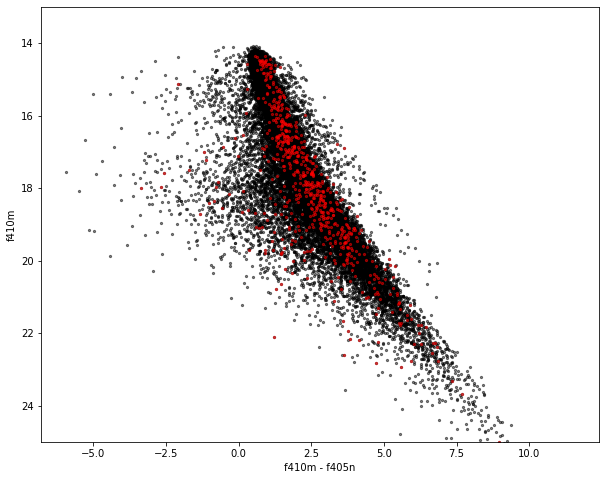

In [103]:
sel = reg.contains(basetable['skycoord_f410m'], ww)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

pl.figure()
pl.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f405n'], basetable['mag_ab_410m405'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_410m405'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

(25.0, 14.0)

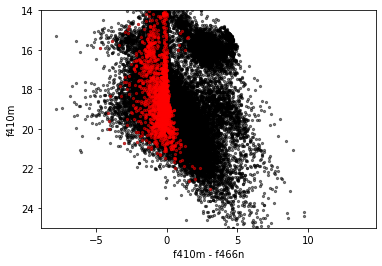

In [32]:
sel = reg.contains(basetable['skycoord_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m")
pl.ylim(25,14)

(-5.0, 10.0, -5.0, 10.0)

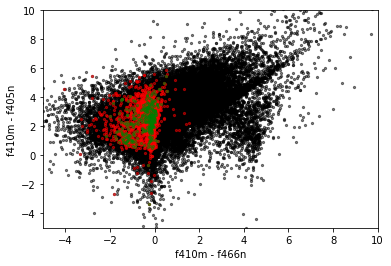

In [33]:
sel = reg.contains(basetable['skycoord_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoord_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

(-5.0, 10.0, -5.0, 10.0)

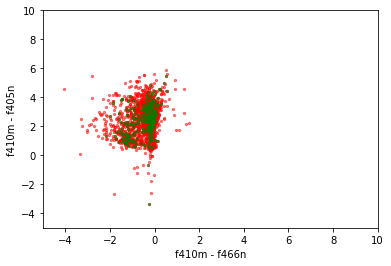

In [34]:
sel = reg.contains(basetable['skycoord_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoord_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
#pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

(-5.0, 10.0, -5.0, 10.0)

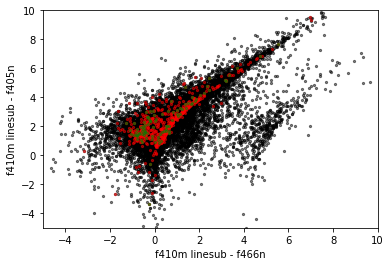

In [35]:
sel = reg.contains(basetable['skycoord_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoord_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'], basetable['mag_ab_410m405']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_410m405']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_410m405']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m linesub - f466n")
pl.ylabel("f410m linesub - f405n")
pl.axis((-5,10,-5,10))

(25.0, 14.0)

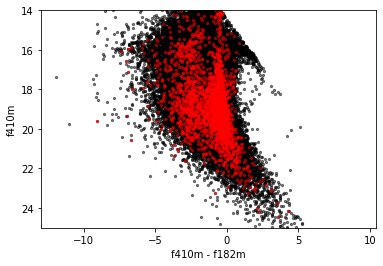

In [36]:
sel = reg.contains(basetable['skycoord_f410m'], ww)
sel &= basetable['sep_f182m'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.xlabel("f410m - f182m")
pl.ylabel("f410m")
pl.ylim(25,14)

(25.0, 14.0)

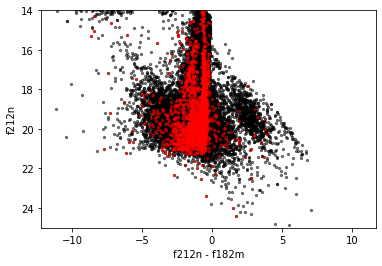

In [37]:
sel = reg.contains(basetable['skycoord_f212n'], ww)
pl.scatter(basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'], basetable['mag_ab_f212n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f212n'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f212n - f182m")
pl.ylabel("f212n")
pl.ylim(25,14)

0arcsec [0arcsec 0arcsec 0arcsec ... 0arcsec 0arcsec 0arcsec]
0arcsec
8.27934e-05arcsec [0.109641arcsec -0.0542358arcsec -0.0325573arcsec ... 0.0250241arcsec
 0.106298arcsec 0.0489123arcsec]
0.000210915arcsec
0.000193884arcsec [-0.0279306arcsec 0.0314312arcsec 0.0521465arcsec ... -0.0192922arcsec
 -0.0214584arcsec -0.207616arcsec]
2.16953e-05arcsec
-4.7755e-05arcsec [-0.0324833arcsec 0.0152397arcsec 0.0303148arcsec ... 0.0443125arcsec
 0.00613865arcsec -0.0802104arcsec]
-1.83879e-05arcsec
6.41633e-05arcsec [0.000874157arcsec -0.0579232arcsec -0.0347385arcsec ... 0.0242927arcsec
 0.104443arcsec 0.0457448arcsec]
0.000276066arcsec
0.000347923arcsec [-0.140433arcsec -0.0524764arcsec -0.0333311arcsec ... 0.0198492arcsec
 0.101377arcsec 0.044585arcsec]
0.000298183arcsec


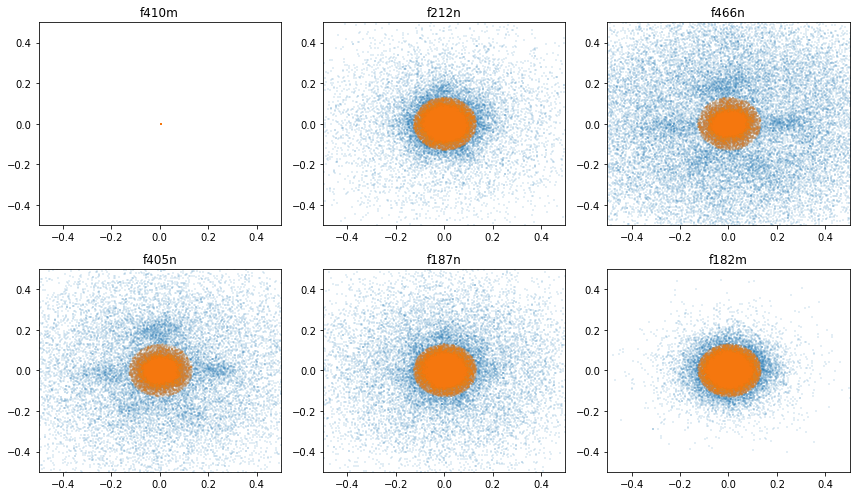

In [38]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoord_f410m']
ii = 1
for tbl in tbls:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoord_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    print(np.median(decdiff))
    ok = (radiff**2 + decdiff**2) < (0.13*u.arcsec)**2
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [39]:
import PIL
import pyavm

In [40]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png'))[::-1,:,:]
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [41]:
# This image shows "CO-absorbed" stars as purple
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrcb_longwave_stars_rotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrcb_longwave_stars_rotated.png'))[::-1,:,:]
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set OBSGEO-B to   -20.644641 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526209006.388 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [42]:
wwi

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.53557138824  -28.68862396733  
CRPIX : 1437.6682598107  1153.3000447229  
PC1_1 PC1_2  : -0.015272821795771  0.99988336365518  
PC2_1 PC2_2  : 0.99988336365518  0.015272821795771  
CDELT : 1.749999206874e-05  1.749999206874e-05  
NAXIS : 2900  2295

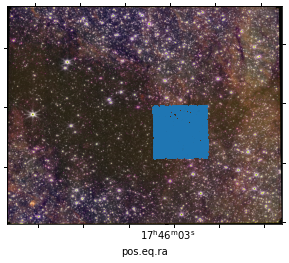

In [43]:
ax = pl.subplot(projection=wwi)
ax.imshow(img)
crds = basetable['skycoord_f410m']
ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('fk5'), marker=',', s=1)

In [44]:
reg.center.to_string('hmsdms')
reg.to_pixel(wwi),img.shape
reg.to_pixel(wwi).to_mask().get_overlap_slices([2296,2900])
mask = reg.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
slcs

(slice(687, 1250, None), slice(1531, 2110, None))

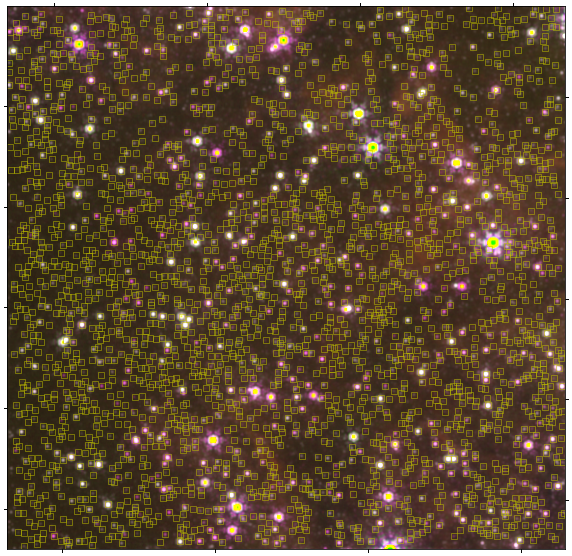

In [45]:
mask = reg.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(10,10))
ax = pl.subplot(projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoord_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby > 2)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  edgecolor='y', facecolor='none', marker='s',
                  alpha=0.5)#r'$\rightarrow$')
                  #c=colorby[sel],
                  #norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

In [46]:

mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
regzoom

<RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (266.53097552, -28.681656)>, width=13.1392 arcsec, height=12.4669 arcsec, angle=0.0 deg)>

In [47]:
regzoom.center.to_string('hmsdms'), reg.center.to_string('hmsdms')


('17h46m07.43412528s -28d40m53.9616108s',
 '17h46m07.62833016s -28d40m55.0634448s')

(25.0, 14.0)

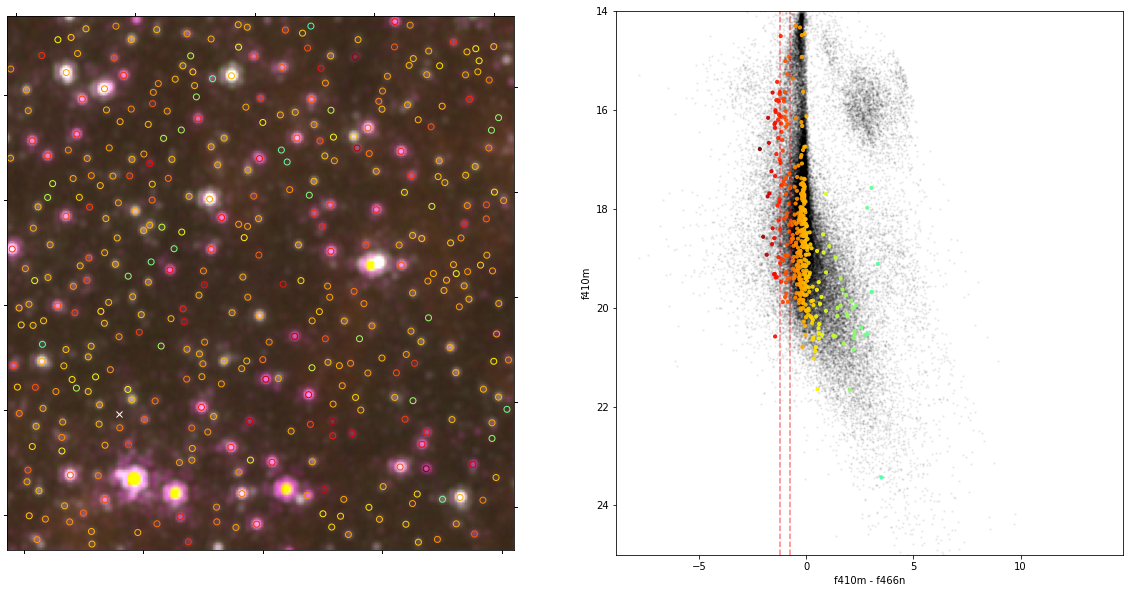

In [48]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoord_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

Set OBSGEO-B to   -20.644641 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526209006.388 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(25.0, 14.0)

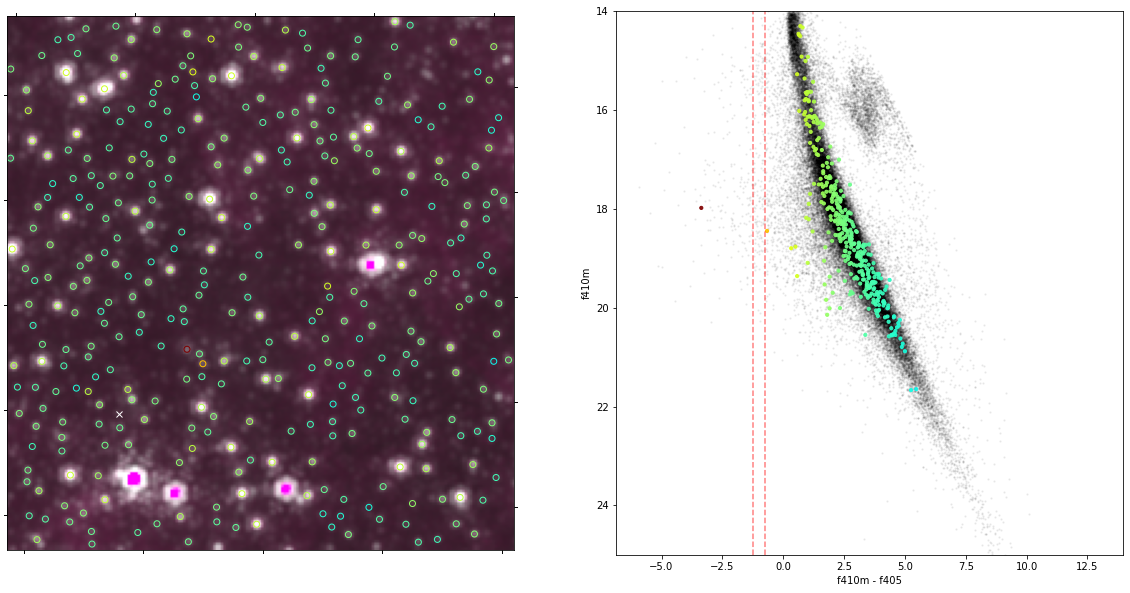

In [49]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrcb_longwave_stars_bra_410.png')
img_bra_410 = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrcb_longwave_stars_bra_410.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_bra_410 = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

mask = regzoom.to_pixel(wwi_bra_410).to_mask()
slcs,_ = mask.get_overlap_slices(img_bra_410.shape[:2])
#co = np.array([mask.cutout(img_bra_410[:,:,ii]) for ii in range(img_bra_410.shape[2])])
co = img_bra_410[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi_bra_410[slcs])
pl.imshow(co)

crds = basetable['skycoord_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi_bra_410[slcs].pixel_to_world(45,55)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f405")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

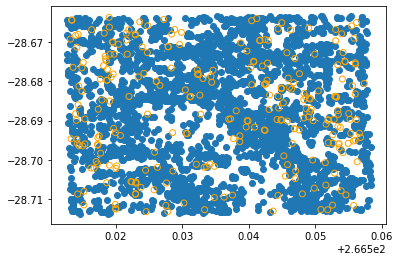

In [50]:
blue_410_466 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']) < -1.25
pl.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466])
blue_410_405 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']) < -1.00
pl.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none')

In [51]:
import warnings

In [52]:
def starzoom(coords):
    reg = regions.RectangleSkyRegion(center=coords, width=1*u.arcsec, height=1*u.arcsec)
    ii = 0
    pl.figure(figsize=(12,4))
    filters_plotted = []
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for fn in sorted(glob.glob(f'{basepath}/F*/pipeline/*nircam*nrc*_i2d.fits')):
            filtername = fits.getheader(fn)['PUPIL']+fits.getheader(fn)['FILTER']
            if filtername in filters_plotted:
                continue
            ww = wcs.WCS(fits.getheader(fn, ext=('SCI',1)))
            if ww.footprint_contains(coords):
                print(fn)
                data = fits.getdata(fn, ext=('SCI',1))
                mask = reg.to_pixel(ww).to_mask()
                slcs,_ = mask.get_overlap_slices(data.shape)
                ax = pl.subplot(1,6,ii+1)
                ax.imshow(data[slcs], norm=simple_norm(data[slcs], stretch='asinh'),
                          origin='lower', cmap='gray')
                xx, yy = ww[slcs].world_to_pixel(coords)
                ax.plot(xx, yy, 'rx')
                ax.set_title(filtername)
                filters_plotted.append(filtername)
                ii += 1

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


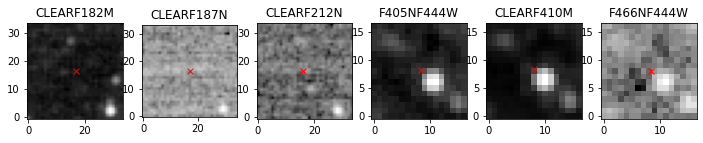

In [53]:
starzoom(coordinates.SkyCoord(266.54177, -28.74910, unit=(u.deg, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


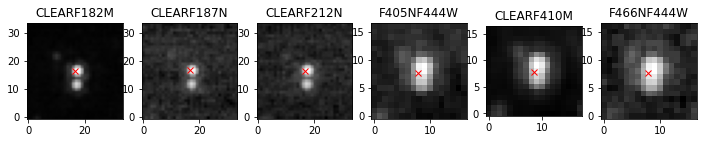

In [54]:
starzoom(coordinates.SkyCoord("17:46:10.006 -28:44:21.00", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


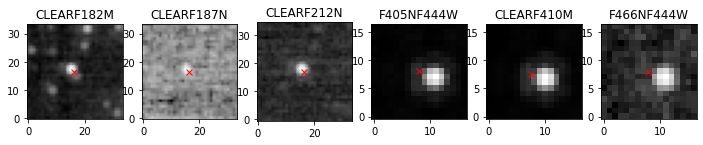

In [55]:
starzoom(coordinates.SkyCoord("17:46:10.682 -28:42:23.87", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


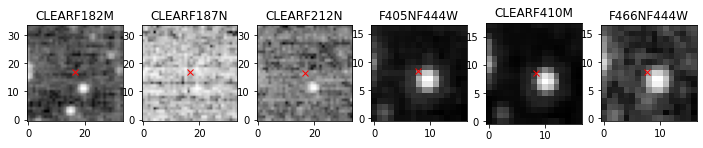

In [56]:
starzoom(coordinates.SkyCoord("17:46:09.310 -28:44:08.95", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


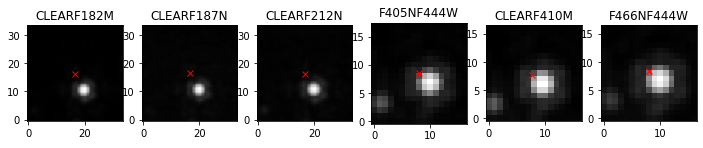

In [57]:
starzoom(coordinates.SkyCoord("17:46:09.256 -28:44:11.15", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


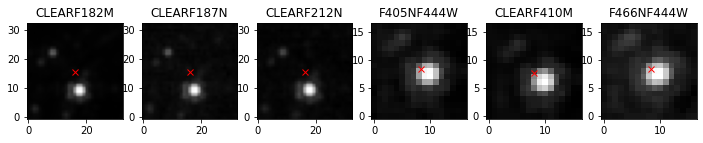

In [58]:
starzoom(coordinates.SkyCoord("17:46:03.833 -28:42:59.76", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca1-test_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca1_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca1_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


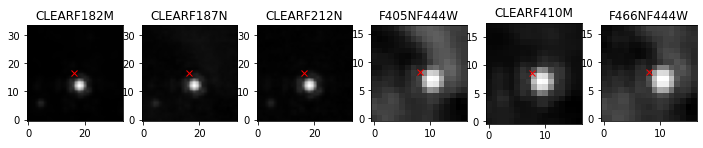

In [59]:
starzoom(coordinates.SkyCoord("17:46:07.378 -28:45:29.38", unit=(u.hour, u.deg), frame='icrs'))

In [60]:
ww410

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.53556406531  -28.688622771691  
CRPIX : 1437.3311541119  1153.1250250745  
PC1_1 PC1_2  : -0.015293060039208  0.99988305431917  
PC2_1 PC2_2  : 0.99988305431917  0.015293060039208  
CDELT : 1.7499991868549e-05  1.7499991868549e-05  
NAXIS : 2899  2295

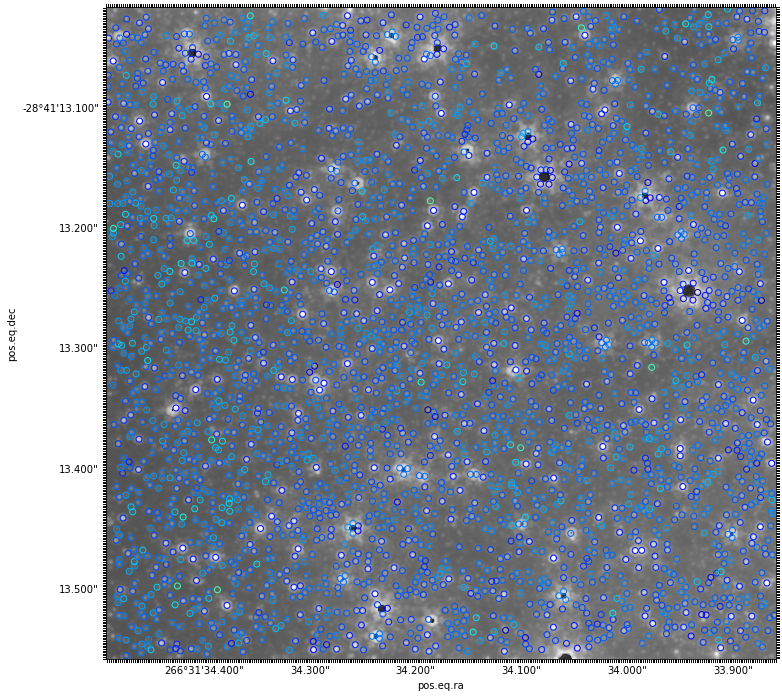

In [61]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410[slcs])
co = mask.cutout(fh['SCI'].data)
co = fh['SCI'].data[slcs]
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoord_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=0.1 * u.arcsec)
lat.set_ticks(spacing=0.1 * u.arcsec)

In [62]:
tbls[0].meta

OrderedDict([('filter', 'f410m')])

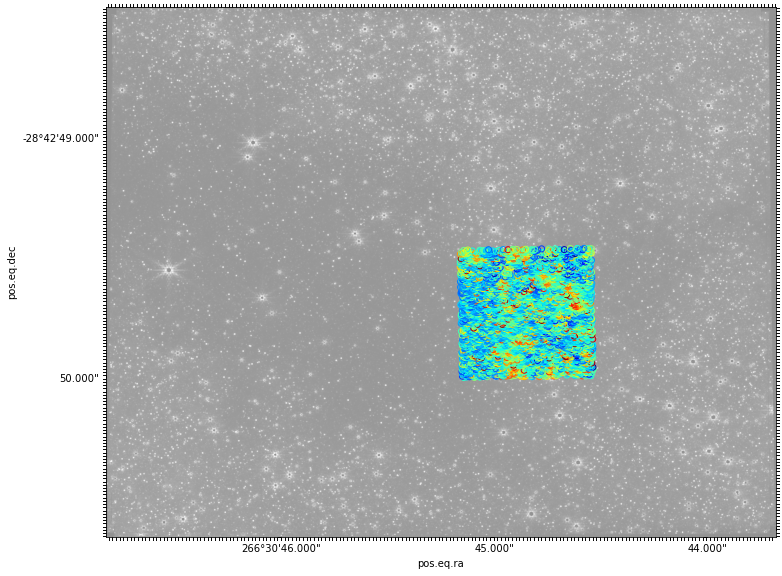

In [63]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoord_f410m']
#crds = tbls[0]['skycoord']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

(676.0, 1043.0, 1119.0, 1515.0)

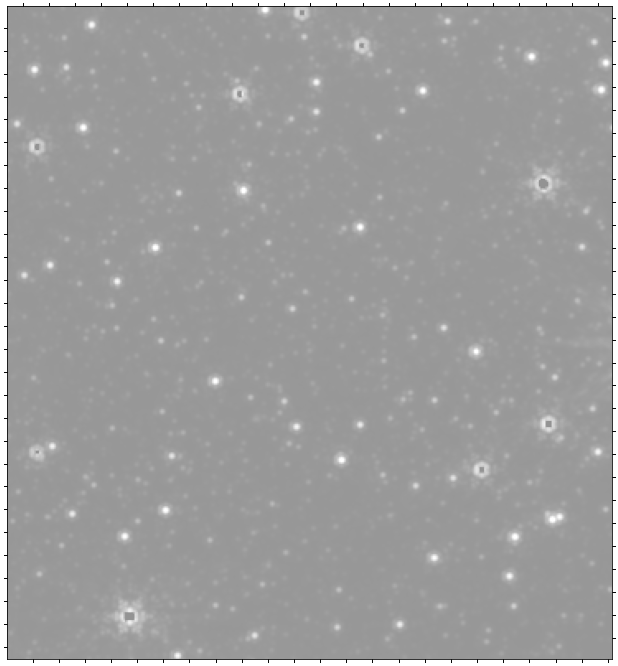

In [64]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoord_f410m']
#crds = tbls[0]['skycoord']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)
ax.axis((676,1043,1119,1515))

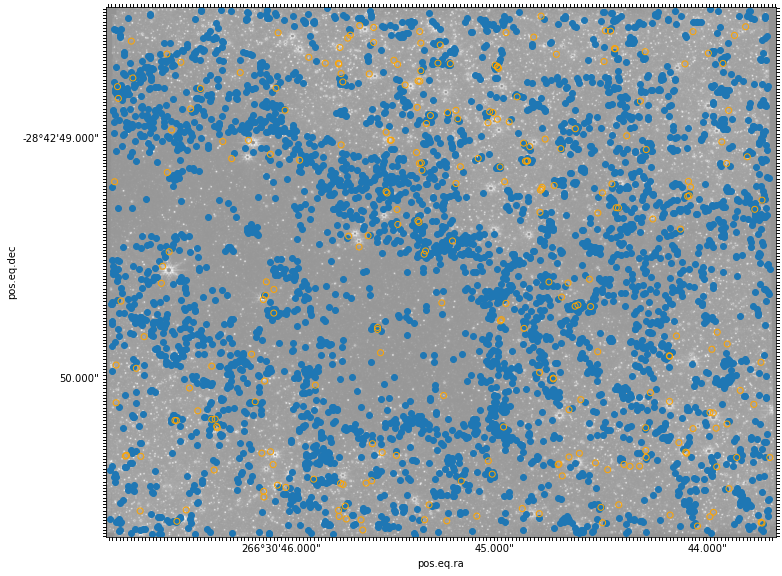

In [65]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoord_f410m']
#crds = tbls[0]['skycoord']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
##scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
##                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
#scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
#           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

blue_410_466 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']) < -1.25
pl.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466], transform=ax.get_transform('world'))
blue_410_405 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']) < -1.00
pl.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


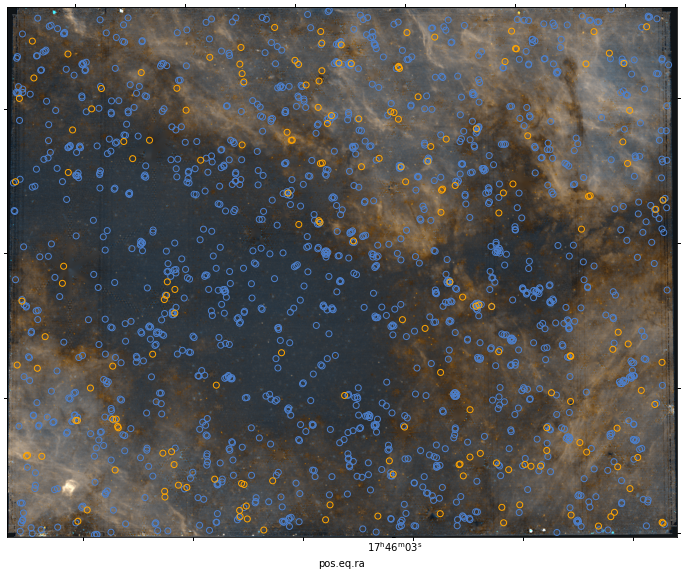

In [66]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrcb_longwave_narrowband_rotated_lighter.png')
img_narrow = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrcb_longwave_narrowband_rotated_lighter.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_narrow = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))


pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_narrow)
ax.imshow(img_narrow)

crds = basetable['skycoord_f410m']
blue_410_466 = (basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']) < -1.75
ax.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466], transform=ax.get_transform('world'), edgecolors=(0.3, 0.5, 0.8), facecolors='none')
blue_410_405 = (basetable['mag_ab_410m405'] - basetable['mag_ab_f405n']) < -1.25
ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))



(25.0, 14.0)

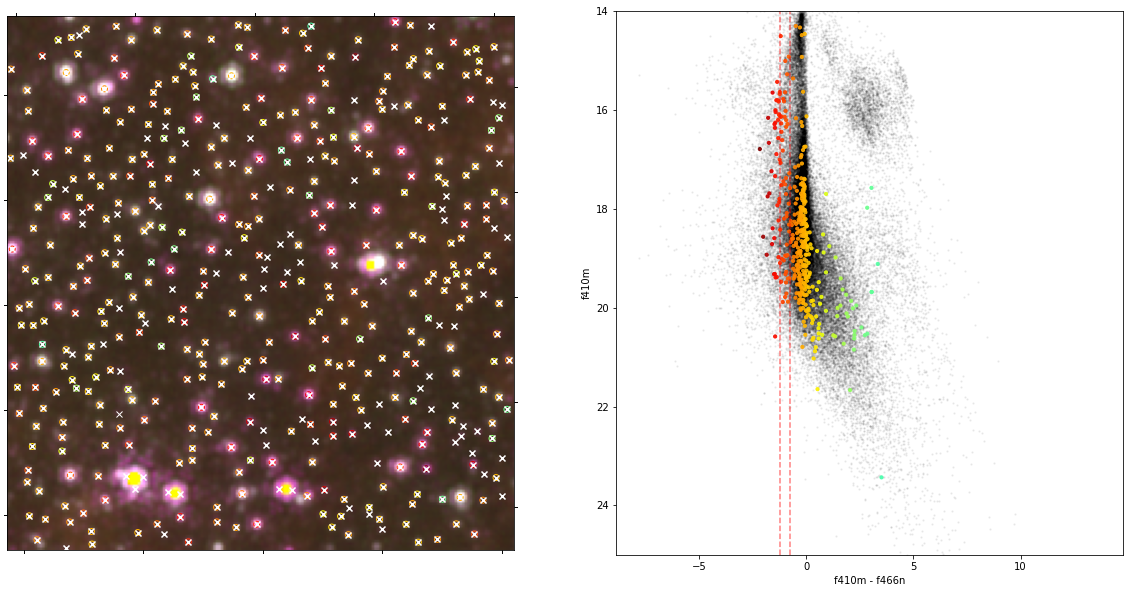

In [67]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoord_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
axlims = ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

# show the maximum detections
sel2 = regzoom.contains(tbls[0]['skycoord'], ww410)
ax.scatter(tbls[0]['skycoord'].ra[sel2], tbls[0]['skycoord'].dec[sel2], marker='x', color='w', transform=ax.get_transform('world'))
ax.axis(axlims)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

(25.0, 14.0)

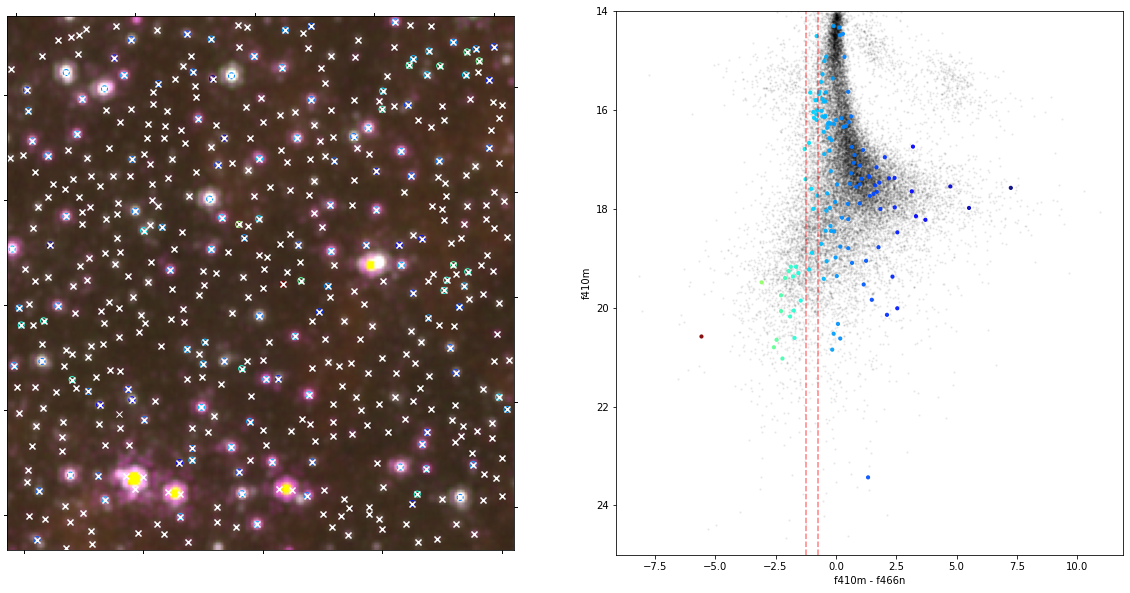

In [68]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoord_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
axlims = ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

# show the maximum detections
sel2 = regzoom.contains(tbls[0]['skycoord'], ww410)
ax.scatter(tbls[0]['skycoord'].ra[sel2], tbls[0]['skycoord'].dec[sel2], marker='x', color='w', transform=ax.get_transform('world'))
ax.axis(axlims)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

(25.0, 12.0)

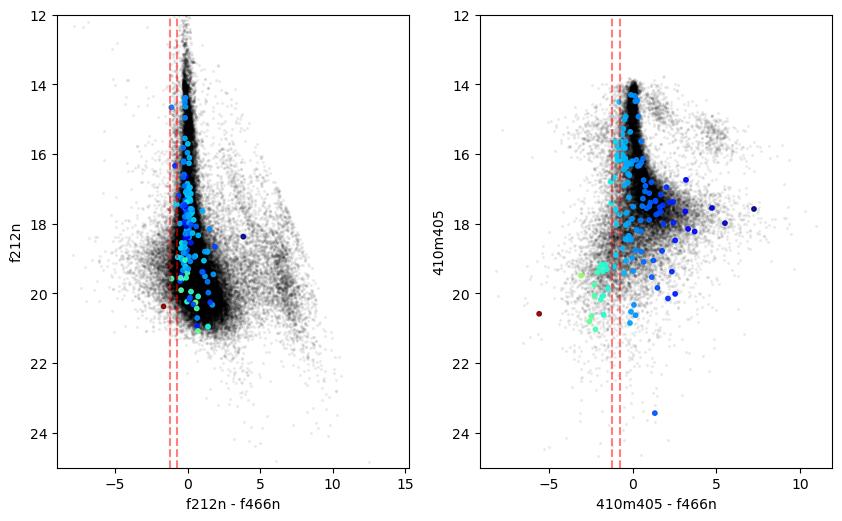

In [69]:
pl.figure(figsize=(10, 6), dpi=100)
ax = pl.subplot(1,2,1)
ax.scatter(basetable['mag_ab_f212n'] - basetable['mag_ab_f466n'], basetable['mag_ab_f212n'], s=2, alpha=0.05, c='k')
ax.scatter((basetable['mag_ab_f212n'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f212n'][sel], s=10, alpha=0.9,
         c=colorby[sel],
         norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
        )
ax.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax.set_ylim(pl.ylim()[::-1])
ax.set_xlabel("f212n - f466n")
ax.set_ylabel("f212n")
ax.set_ylim(25,12)


ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("410m405 - f466n")
ax2.set_ylabel("410m405")
ax2.set_ylim(25,12)

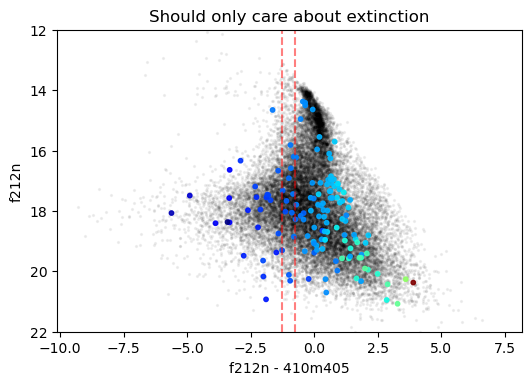

In [70]:
pl.figure(dpi=100)
ax = pl.subplot(1,1,1,)
ax.set_title("Should only care about extinction")
ax.scatter(basetable['mag_ab_f212n'] - basetable['mag_ab_410m405'], basetable['mag_ab_f212n'], s=2, alpha=0.05, c='k')
ax.scatter((basetable['mag_ab_f212n'] - basetable['mag_ab_410m405'])[sel], basetable['mag_ab_f212n'][sel], s=10, alpha=0.9,
         c=colorby[sel],
         norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
        )
ax.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax.set_ylim(pl.ylim()[::-1])
ax.set_xlabel("f212n - 410m405")
ax.set_ylabel("f212n")
ax.set_ylim(22,12);

In [71]:
fh212 = fits.open(f'{basepath}/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb_i2d.fits')
ww212 = wcs.WCS(fh212[1].header)
im212 = fh212['SCI'].data

Set OBSGEO-B to   -20.665528 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526454427.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(25.0, 14.0)

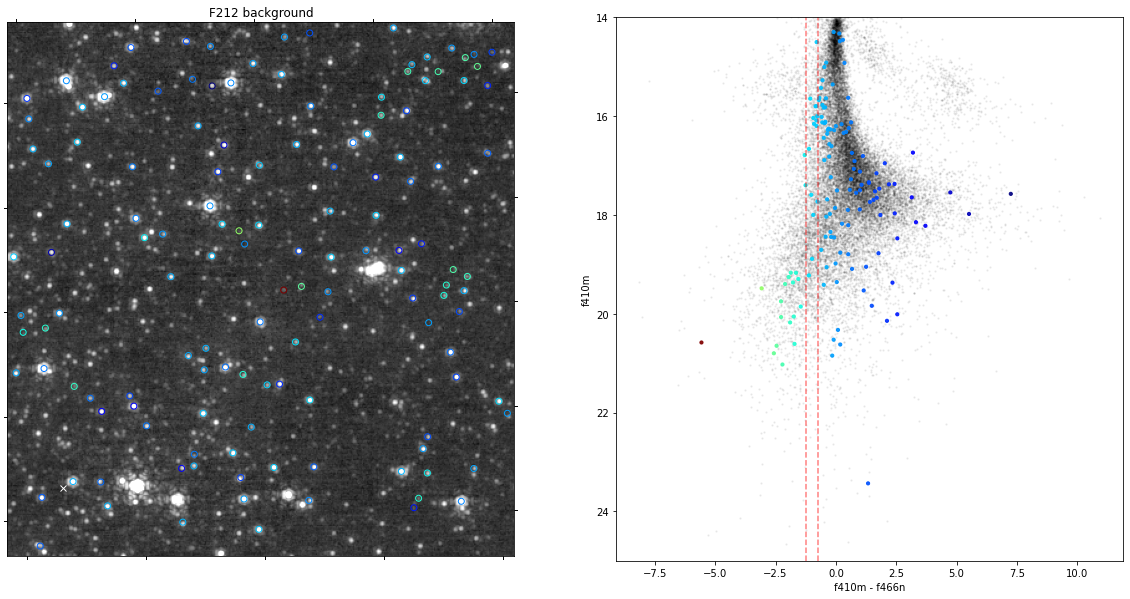

In [72]:
mask = regzoom.to_pixel(ww212).to_mask()
slcs,_ = mask.get_overlap_slices(im212.shape[:2])
co = im212[slcs[0], slcs[1]]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=ww212[slcs])
pl.imshow(co, cmap='gray', norm=simple_norm(co, stretch='asinh', max_percent=99.5))
ax.set_title("F212 background")

crds = basetable['skycoord_f410m']
sel = regzoom.contains(crds, ww212)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww212[slcs].world_to_pixel(crds[sel])

colorby = basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
axlims = ax.axis()
pl.plot(44,54, 'wx')
# show the maximum detections
#sel2 = regzoom.contains(tbls[0]['skycoord'], ww410)
#ax.scatter(tbls[0]['skycoord'].ra[sel2], tbls[0]['skycoord'].dec[sel2], marker='x', color='w', transform=ax.get_transform('world'))
ax.axis(axlims)



ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)